In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = '../../DATA/raw/Fraud Detection/Transaction.csv'
df=pd.read_csv(path)
df_exp = df.copy()
df_exp['type'] = df_exp['type'].str.upper()


In [3]:
df_hi = df_exp[df_exp['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()
df_hi['type'].value_counts(), df_hi['isFraud'].value_counts()


(type
 CASH_OUT    2237500
 TRANSFER     532909
 Name: count, dtype: int64,
 isFraud
 0    2762196
 1       8213
 Name: count, dtype: int64)

In [4]:
EPS = 1e-6

# --- Type risk flags ---
df_hi['is_transfer'] = (df_hi['type'] == 'TRANSFER').astype(int)
df_hi['is_cash_out'] = (df_hi['type'] == 'CASH_OUT').astype(int)

# --- Origin (victim) behavior ---
df_hi['orig_balance_delta'] = df_hi['oldbalanceOrg'] - df_hi['newbalanceOrig']
df_hi['orig_drop_ratio'] = df_hi['orig_balance_delta'] / (df_hi['oldbalanceOrg'] + EPS)
df_hi['orig_post_ratio'] = df_hi['newbalanceOrig'] / (df_hi['oldbalanceOrg'] + EPS)
df_hi['amount_to_oldbalanceOrg'] = df_hi['amount'] / (df_hi['oldbalanceOrg'] + EPS)
df_hi['orig_zero_before'] = (df_hi['oldbalanceOrg'] == 0).astype(int)

# --- Destination (mule) behavior ---
df_hi['dest_balance_delta'] = df_hi['newbalanceDest'] - df_hi['oldbalanceDest']
df_hi['dest_gain_ratio'] = df_hi['dest_balance_delta'] / (df_hi['oldbalanceDest'] + EPS)
df_hi['dest_enrichment_ratio'] = df_hi['newbalanceDest'] / (df_hi['oldbalanceDest'] + EPS)
df_hi['amount_to_oldbalanceDest'] = df_hi['amount'] / (df_hi['oldbalanceDest'] + EPS)
df_hi['dest_zero_before'] = (df_hi['oldbalanceDest'] == 0).astype(int)

# --- Accounting consistency (often strongest in PaySim) ---
df_hi['error_balance_org'] = (df_hi['newbalanceOrig'] + df_hi['amount']) - df_hi['oldbalanceOrg']
df_hi['error_balance_dest'] = (df_hi['oldbalanceDest'] + df_hi['amount']) - df_hi['newbalanceDest']
df_hi['abs_error_org'] = df_hi['error_balance_org'].abs()
df_hi['abs_error_dest'] = df_hi['error_balance_dest'].abs()

# --- Time signals ---
df_hi['hour'] = df_hi['step'] % 24
df_hi['day'] = df_hi['step'] // 24

# --- Scale help ---
df_hi['log_amount'] = np.log1p(df_hi['amount'])


In [5]:
candidate_features = [
    'log_amount',
    'orig_balance_delta','orig_drop_ratio','orig_post_ratio','amount_to_oldbalanceOrg','orig_zero_before',
    'dest_balance_delta','dest_gain_ratio','dest_enrichment_ratio','amount_to_oldbalanceDest','dest_zero_before',
    'abs_error_org','abs_error_dest',
    'hour','day',
    'is_transfer','is_cash_out'
]

summary = df_hi.groupby('isFraud')[candidate_features].agg(['mean','median'])
summary


log_amount            orig_balance_delta            orig_drop_ratio  \
              mean     median               mean     median            mean   
isFraud                                                                       
0        11.924932  12.049626       2.731199e+04     278.00        0.472186   
1        12.892027  12.997762       1.457275e+06  436317.49        0.985975   

                  orig_post_ratio        amount_to_oldbalanceOrg              \
           median            mean median                    mean      median   
isFraud                                                                        
0        0.220301        0.054082    0.0            1.580385e+11  635.967394   
1        1.000000        0.009033    0.0            1.160973e+09    1.000000   

         ... abs_error_dest                hour               day         \
         ...           mean   median       mean median       mean median   
isFraud  ...                                                               
0        ...   44302.660832     0.00  15.319966   16.0   9.429677    9.0   
1        ...  745138.585637  9511.69  11.546451   12.0  14.869475   15.0   

        is_transfer        is_cash_out         
               mean median        mean median  
isFraud                                        
0          0.191446    0.0    0.808554    1.0  
1          0.498843    0.0    0.501157    1.0  

[2 rows x 34 columns]

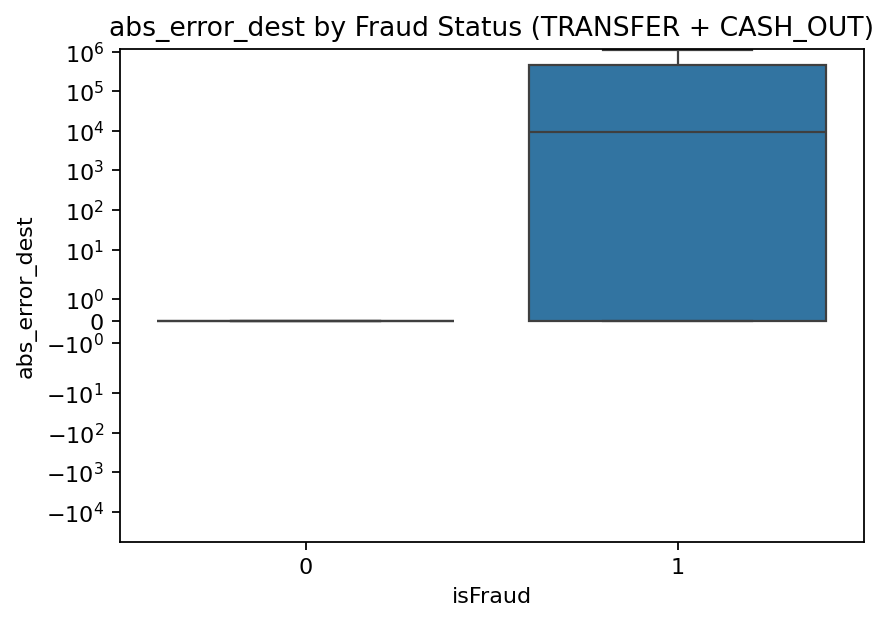

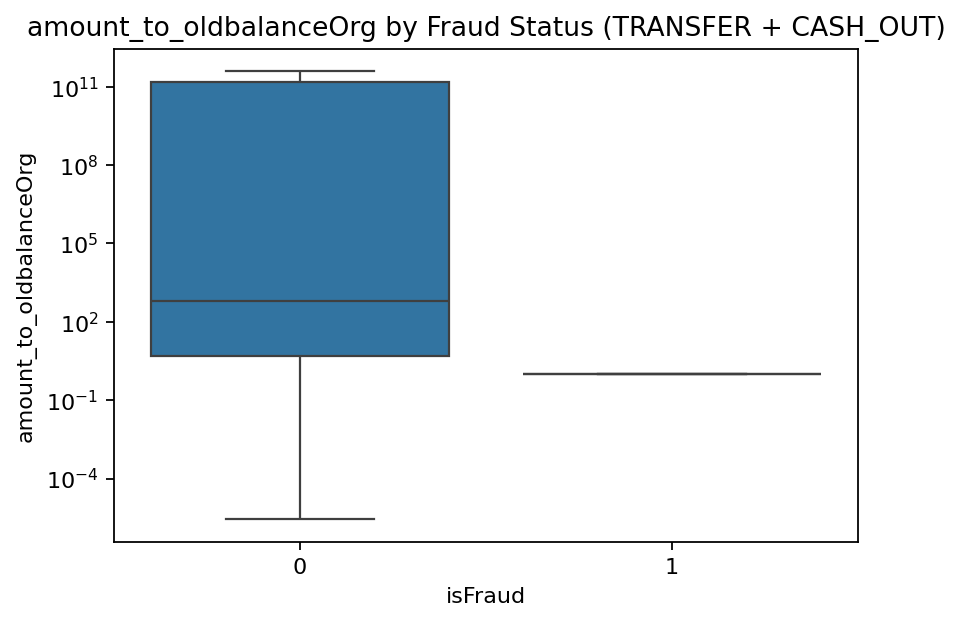

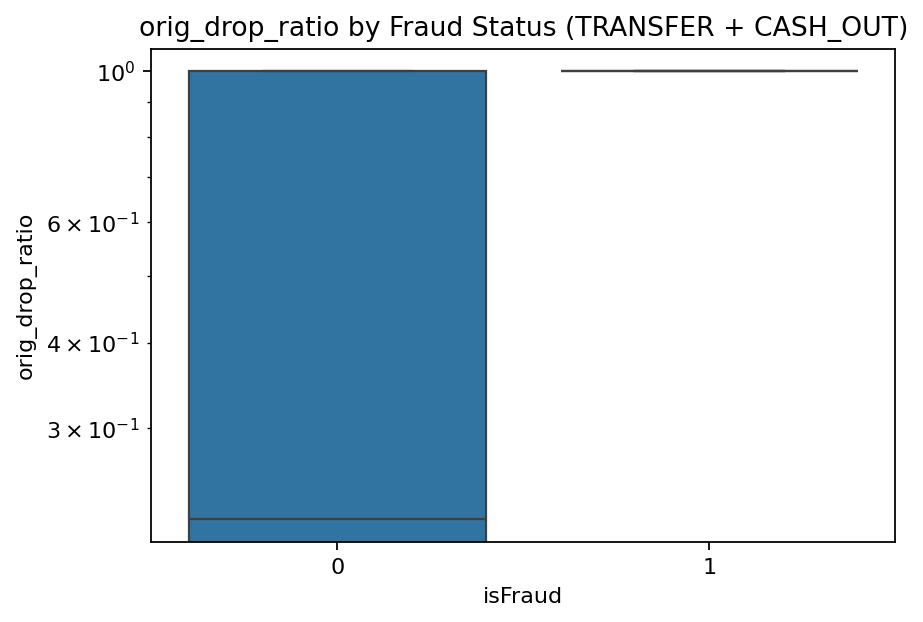

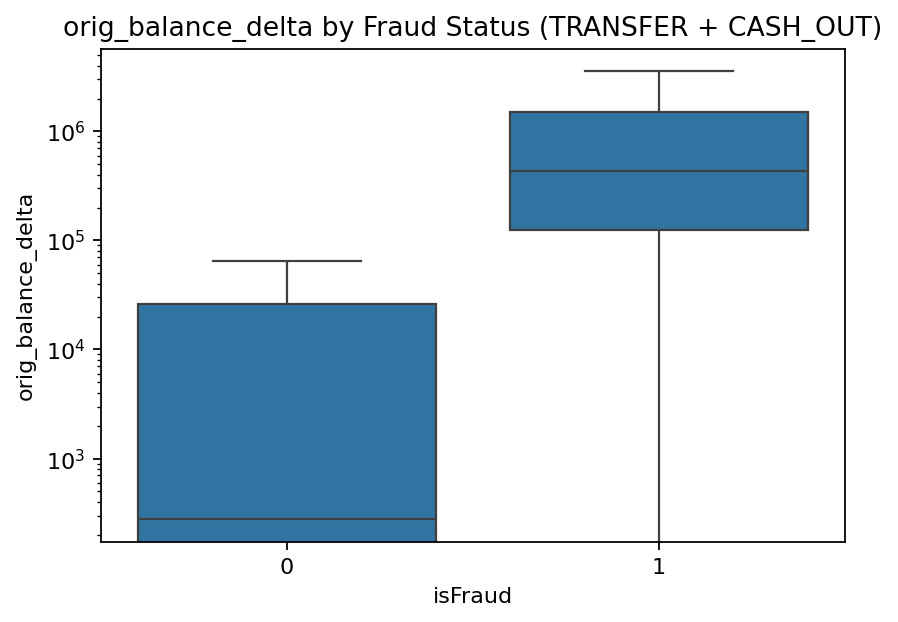

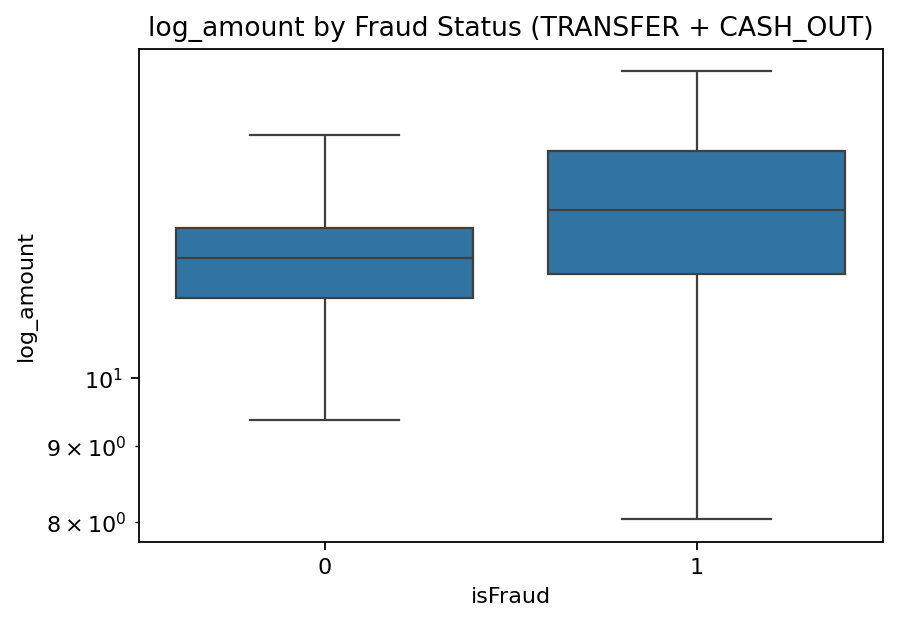

In [6]:
top_to_plot = [
    'abs_error_dest',
    'amount_to_oldbalanceOrg',
    'orig_drop_ratio',
    'orig_balance_delta',
    'log_amount'
]

for feat in top_to_plot:
    plt.figure(figsize=(6,4), dpi=160)
    sns.boxplot(data=df_hi, x='isFraud', y=feat, showfliers=False)
    plt.yscale('symlog') if 'error' in feat else plt.yscale('log')
    plt.title(f"{feat} by Fraud Status (TRANSFER + CASH_OUT)")
    plt.show()


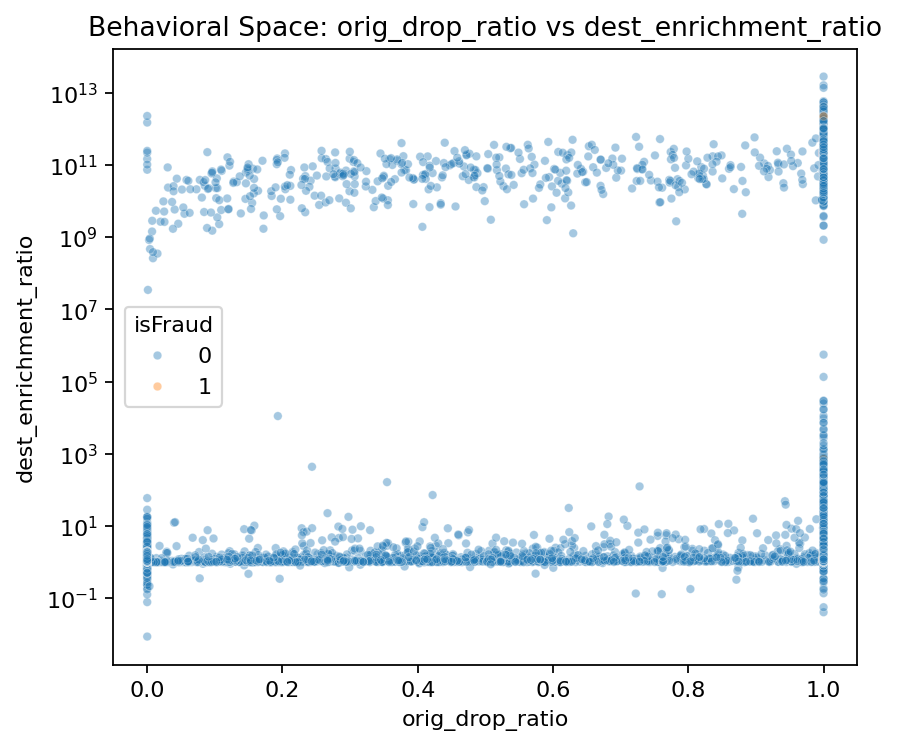

In [7]:
plt.figure(figsize=(6,5), dpi=160)
sns.scatterplot(
    data=df_hi.sample(20000, random_state=42),
    x='orig_drop_ratio',
    y='dest_enrichment_ratio',
    hue='isFraud',
    alpha=0.4,
    s=15
)
plt.yscale('log')
plt.title("Behavioral Space: orig_drop_ratio vs dest_enrichment_ratio")
plt.show()


In [8]:
rule_flag = (df_hi['dest_zero_before'] == 1) & (df_hi['dest_enrichment_ratio'] > 10)
pd.crosstab(rule_flag, df_hi['isFraud'], normalize='index')


isFraud,0,1
row_0,,
False,0.997093,0.002907
True,0.996676,0.003324
